In [1]:
import pandas as pd

pd.set_option('display.max_columns', 100)

df_mod = pd.read_parquet('../../data/model_data/model_data_single_output.parquet')

df_mod = df_mod.loc[df_mod['Position'] == 'DST', :].reset_index(drop=True)

df_mod

,Season,Week,Name,Position,Team,Fantasy Points,Rank,Position Rank,Adjusted Passing Yards Projection,Adjusted Passing Touchdowns Projection,Adjusted Interceptions Projection,Adjusted Rushing Yards Projection,Adjusted Receiving Yards Projection,Adjusted Receptions Projection,Anytime Touchdown Probability,Location,Team Projected Score,Opponent Projected Score
0,2020,1,Buffalo Bills,DST,BUF,8.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,23.75,17.25
1,2020,1,Pittsburgh Steelers,DST,PIT,8.0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,25.00,19.00
2,2020,1,Baltimore Ravens,DST,BAL,15.0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.25,20.25
3,2020,1,New England Patriots,DST,NE,11.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,24.50,17.00
4,2020,1,Philadelphia Eagles,DST,PHI,3.0,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,22.00,16.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2023,17,Cincinnati Bengals,DST,CIN,4.0,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,19.50,26.50
2012,2023,17,Detroit Lions,DST,DET,6.0,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,24.50,29.00
2013,2023,17,New York Giants,DST,NYG,16.0,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.75,24.75
2014,2023,17,Arizona Cardinals,DST,ARI,2.0,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,17.75,30.25


In [2]:
X = df_mod[[
    'Position Rank',
    'Location',
    'Team Projected Score',
    'Opponent Projected Score',
]].copy()

X

,Position Rank,Location,Team Projected Score,Opponent Projected Score
0,1,1.0,23.75,17.25
1,2,-1.0,25.00,19.00
2,3,1.0,27.25,20.25
3,4,1.0,24.50,17.00
4,5,-1.0,22.00,16.50
...,...,...,...,...
2011,28,-1.0,19.50,26.50
2012,29,-1.0,24.50,29.00
2013,30,1.0,18.75,24.75
2014,31,-1.0,17.75,30.25


In [3]:
y = df_mod['Fantasy Points'].copy()

y

0        8.0
1        8.0
2       15.0
3       11.0
4        3.0
        ... 
2011     4.0
2012     6.0
2013    16.0
2014     2.0
2015     1.0
Name: Fantasy Points, Length: 2016, dtype: float64

In [4]:
groups = df_mod['Season'].astype(str) + ' Week ' + df_mod['Week'].astype(str)

groups

0        2020 Week 1
1        2020 Week 1
2        2020 Week 1
3        2020 Week 1
4        2020 Week 1
            ...     
2011    2023 Week 17
2012    2023 Week 17
2013    2023 Week 17
2014    2023 Week 17
2015    2023 Week 17
Length: 2016, dtype: object

In [5]:
df_folds = pd.read_parquet('../../data/model_data/folds.parquet')

df_folds

,Fold ID,Season Week
0,0,2022 Week 3
1,0,2021 Week 7
2,0,2021 Week 1
3,0,2023 Week 16
4,0,2021 Week 11
...,...,...
62,2,2020 Week 15
63,2,2023 Week 14
64,2,2021 Week 5
65,2,2022 Week 6


In [6]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.options.mode.chained_assignment = None

# splitter = GroupKFold(n_splits=3)

cv_data = []
for fold in df_folds['Fold ID'].unique():
    oos_season_week = df_folds.loc[df_folds['Fold ID'] == fold, 'Season Week']
    is_indexes = df_mod.loc[~groups.isin(oos_season_week), :].index
    oos_indexes = df_mod.loc[groups.isin(oos_season_week), :].index
    # split
    X_is = X.iloc[is_indexes]
    X_oos = X.iloc[oos_indexes]

    y_is = y.iloc[is_indexes]
    y_oos = y.iloc[oos_indexes]

    groups_is = groups.iloc[is_indexes]
    df_mod_oos = df_mod.iloc[oos_indexes]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
    for train_indexes, val_indexes in gss.split(X=X_is, y=y_is, groups=groups_is):
        X_train = X_is.iloc[train_indexes]
        X_val = X_is.iloc[val_indexes]

        y_train = y_is.iloc[train_indexes]
        y_val = y_is.iloc[val_indexes]

    # impute
    # scaler = StandardScaler()
    # imputer = IterativeImputer(initial_strategy='median', max_iter=100)

    # X_train_fill_na = imputer.fit_transform(scaler.fit_transform(X_train))
    # X_train[X_train.columns] = scaler.inverse_transform(X_train_fill_na).copy()
    # X_train['Prop Bets Projection'] = (
    #     X_train['Adjusted Receiving Yards Projection']*0.1 + 
    #     X_train['Adjusted Receptions Projection']*0.5 + 
    #     X_train['Anytime Touchdown Probability']*6
    # )

    # X_val_fill_na = imputer.transform(scaler.transform(X_val))
    # X_val[X_val.columns] = scaler.inverse_transform(X_val_fill_na).copy()
    # X_val['Prop Bets Projection'] = (
    #     X_val['Adjusted Receiving Yards Projection']*0.1 + 
    #     X_val['Adjusted Receptions Projection']*0.5 + 
    #     X_val['Anytime Touchdown Probability']*6
    # )

    # X_oos_fill_na = imputer.transform(scaler.transform(X_oos))
    # X_oos[X_oos.columns] = scaler.inverse_transform(X_oos_fill_na).copy()
    # X_oos['Prop Bets Projection'] = (
    #     X_oos['Adjusted Receiving Yards Projection']*0.1 + 
    #     X_oos['Adjusted Receptions Projection']*0.5 + 
    #     X_oos['Anytime Touchdown Probability']*6
    # )

    # X_train.drop(columns=['Adjusted Passing Yards Projection', 'Adjusted Passing Touchdowns Projection', 'Adjusted Interceptions Projection', 'Adjusted Rushing Yards Projection', 'Anytime Touchdown Probability'], inplace=True)
    # X_val.drop(columns=['Adjusted Passing Yards Projection', 'Adjusted Passing Touchdowns Projection', 'Adjusted Interceptions Projection', 'Adjusted Rushing Yards Projection', 'Anytime Touchdown Probability'], inplace=True)
    # X_oos.drop(columns=['Adjusted Passing Yards Projection', 'Adjusted Passing Touchdowns Projection', 'Adjusted Interceptions Projection', 'Adjusted Rushing Yards Projection', 'Anytime Touchdown Probability'], inplace=True)

    cv_data.append((X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos))

for X_train, X_val, X_oos, y_train, y_val, y_oos, df_mod_oos in cv_data:
    print(X_train.shape, X_val.shape, X_oos.shape, y_train.shape, y_val.shape, y_oos.shape, df_mod_oos.shape)

(1106, 4) (216, 4) (694, 4) (1106,) (216,) (694,) (694, 18)
(1156, 4) (212, 4) (648, 4) (1156,) (212,) (648,) (648, 18)
(1138, 4) (204, 4) (674, 4) (1138,) (204,) (674,) (674, 18)


In [7]:
monotonic_contraints_dict = {
    'Position Rank': -1,
    'Location': 1,
    'Opponent Projected Score': -1,
}

monotone_contraints = [monotonic_contraints_dict.get(c, 0) for c in X_train.columns]

monotone_contraints

[-1, 1, 0, -1]

In [8]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import optuna
import numpy as np

def objective(trial, cv_data=cv_data):
    # model tuning
    # params = {
    #     'random_state': 22,
    #     'objective': 'binary:logistic',
    #     'eval_metric': 'logloss',
    #     'n_estimators': 1_000,
    #     'eta': trial.suggest_float('eta', 0.005, 0.100),
    #     'max_depth': trial.suggest_int('max_depth', 4, 16),
    #     'lambda': trial.suggest_float('lambda', 1e-8, 5.0),
    #     'alpha': trial.suggest_float('alpha', 1e-8, 5.0),
    #     'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 5.0),
    #     # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 0.30),
    # }
    params = {
        'random_state': 22,
        'metric': 'mean_squared_error',
        'verbosity': -1,
        'n_estimators': 500,
        'early_stopping_round': 25,
        'monotone_constraints': monotone_contraints,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**8),
        'feature_fraction': trial.suggest_float('feature_fraction', 1e-8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    mod = LGBMRegressor(**params)

    # cross validation
    y_actuals = []
    y_preds = []
    for X_train, X_val, X_test, y_train, y_val, y_test, df_mod_oos in cv_data:
        y_actuals.append(y_test)

        mod.fit(
            X_train, 
            y_train, 
            eval_set=(X_val, y_val),
        )

        y_preds.append(mod.predict(X_test))

    return mean_squared_error(np.hstack(y_actuals), np.hstack(y_preds), squared=False)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=22, n_startup_trials=50, multivariate=True))
study.optimize(objective, n_trials=500, show_progress_bar=True)

study.best_params

c:\Users\mhugh\anaconda3\envs\clean\lib\site-packages\optuna\samplers\_tpe\sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-10-16 21:17:43,575] A new study created in memory with name: no-name-05755ca5-e740-499c-9230-9861170240ed


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2024-10-16 21:17:43,713] Trial 0 finished with value: 5.669170130908949 and parameters: {'lambda_l1': 2.084605381503821, 'lambda_l2': 4.816810622816848, 'max_depth': 14, 'num_leaves': 221, 'feature_fraction': 0.17116156190005774, 'min_child_samples': 34}. Best is trial 0 with value: 5.669170130908949.
[I 2024-10-16 21:17:43,758] Trial 1 finished with value: 5.66755038113867 and parameters: {'lambda_l1': 2.7053283402729833, 'lambda_l2': 6.910413507585547, 'max_depth': 8, 'num_leaves': 209, 'feature_fraction': 0.010526884210839693, 'min_child_samples': 57}. Best is trial 1 with value: 5.66755038113867.
[I 2024-10-16 21:17:43,801] Trial 2 finished with value: 5.682040064080244 and parameters: {'lambda_l1': 8.137261876014703, 'lambda_l2': 7.451002963137353, 'max_depth': 7, 'num_leaves': 3, 'feature_fraction': 0.7720438737240976, 'min_child_samples': 96}. Best is trial 1 with value: 5.66755038113867.
[I 2024-10-16 21:17:43,858] Trial 3 finished with value: 5.690894615122383 and parameter

{'lambda_l1': 8.815367975284028,
 'lambda_l2': 0.231659066284622,
 'max_depth': 27,
 'num_leaves': 3,
 'feature_fraction': 0.2976720227715186,
 'min_child_samples': 71}

In [9]:
params = (
    {
        'random_state': 22,
        'metric': 'mean_squared_error',
        'verbosity': -1,
        'n_estimators': 500,
        'early_stopping_round': 25,
        'monotone_constraints': monotone_contraints,
    } |
    study.best_params
)

testing_data = []
mod = LGBMRegressor(**params)
for X_train, X_val, X_test, y_train, y_val, y_test, df_mod_oos in cv_data:
    mod.fit(
        X_train, 
        y_train, 
        eval_set=(X_val, y_val),
    )
    
    testing_data.append(df_mod_oos.assign(Prediction=mod.predict(X_test)))

df_test = pd.concat(testing_data, ignore_index=True)

df_test

,Season,Week,Name,Position,Team,Fantasy Points,Rank,Position Rank,Adjusted Passing Yards Projection,Adjusted Passing Touchdowns Projection,Adjusted Interceptions Projection,Adjusted Rushing Yards Projection,Adjusted Receiving Yards Projection,Adjusted Receptions Projection,Anytime Touchdown Probability,Location,Team Projected Score,Opponent Projected Score,Prediction
0,2020,5,Los Angeles Rams,DST,LAR,12.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,25.50,18.50,7.644398
1,2020,5,Baltimore Ravens,DST,BAL,26.0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30.50,18.50,7.761482
2,2020,5,Pittsburgh Steelers,DST,PIT,8.0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,25.75,18.25,7.761482
3,2020,5,San Francisco 49ers,DST,SF,-2.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,29.50,21.00,7.761482
4,2020,5,Tampa Bay Buccaneers,DST,TB,6.0,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,23.75,20.25,7.644398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2023,17,Cincinnati Bengals,DST,CIN,4.0,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,19.50,26.50,5.762285
2012,2023,17,Detroit Lions,DST,DET,6.0,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,24.50,29.00,5.554877
2013,2023,17,New York Giants,DST,NYG,16.0,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.75,24.75,5.581914
2014,2023,17,Arizona Cardinals,DST,ARI,2.0,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,17.75,30.25,5.182892


In [10]:
df_test['Prediction'].describe()

count    2016.000000
mean        6.627756
std         0.972317
min         5.018166
25%         5.762285
50%         6.558388
75%         7.495773
max         8.906754
Name: Prediction, dtype: float64

In [11]:
(df_test['Fantasy Points'] - df_test['Prediction']).describe()

count    2016.000000
mean        0.040399
std         5.656666
min       -12.407007
25%        -3.697462
50%        -0.943749
75%         2.933487
max        29.708966
dtype: float64

In [12]:
(df_test['Fantasy Points'] - df_test['Prediction']).abs().describe()

count    2016.000000
mean        4.343544
std         3.622675
min         0.014205
25%         1.662322
50%         3.475468
75%         6.018166
max        29.708966
dtype: float64

In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['Fantasy Points'], df_test['Prediction'], squared=False)

5.655407624253706

In [14]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_test['Fantasy Points'], df_test['Prediction'])

4.343543734344031

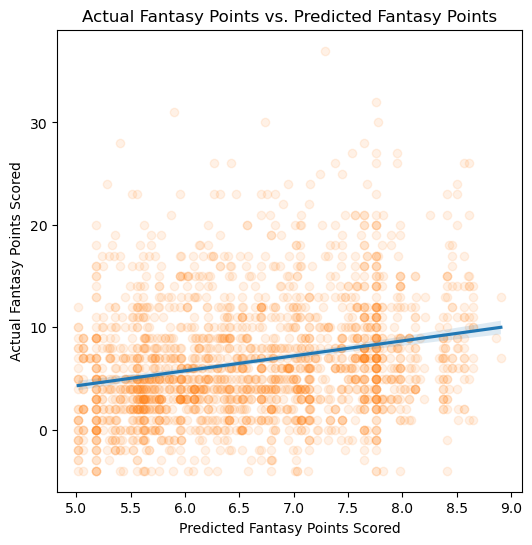

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6), dpi=100)

ax = sns.regplot(
    data=df_test,
    x='Prediction',
    y='Fantasy Points',
    scatter_kws={'alpha': 0.10, 'color': sns.color_palette()[1]},
    line_kws={'color': sns.color_palette()[0]},
)

plt.title('Actual Fantasy Points vs. Predicted Fantasy Points')
plt.xlabel('Predicted Fantasy Points Scored')
plt.ylabel('Actual Fantasy Points Scored')

plt.show()

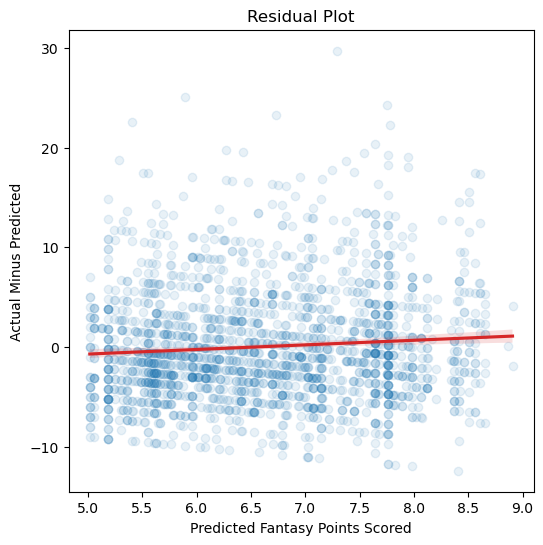

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6), dpi=100)

ax = sns.regplot(
    data=df_test.assign(f=(df_test['Fantasy Points'] - df_test['Prediction'])),
    x='Prediction',
    y='f',
    scatter_kws={'alpha': 0.10, 'color': sns.color_palette()[0]},
    line_kws={'color': sns.color_palette()[3]},
)

plt.title('Residual Plot')
plt.xlabel('Predicted Fantasy Points Scored')
plt.ylabel('Actual Minus Predicted')

plt.show()

In [17]:
import shap

explainer = shap.Explainer(mod, feature_names=X_train.columns, seed=22)

shap_values = explainer(pd.concat([i[0] for i in cv_data], ignore_index=True))

shap_values.shape

(3400, 4)

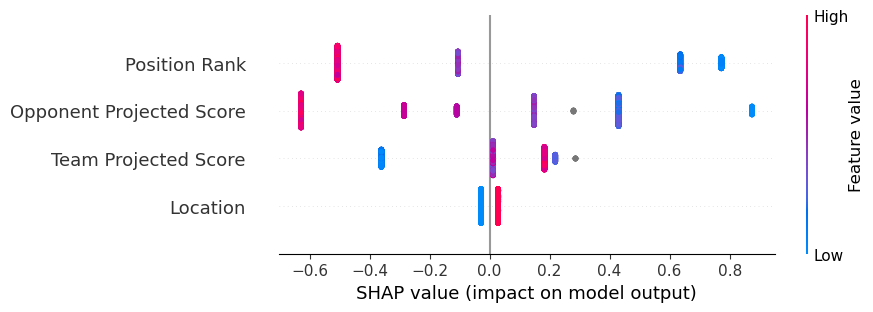

In [18]:
shap.plots.beeswarm(shap_values, max_display=None)